# Laplacian of Gaussian with Difference of Gaussian
The Laplacian of Gaussian (LoG) can be used to detect blobs in images. Classic methods using the LoG blur the image with differing amounts to reduce the effect of noise, especially since the LoG requires second-order derivatives.

David Lowe found that the LoG can be approximated with a difference of Gaussians with increasing sigmas. Combining this with an image pyramid, he created the scale-invariant feature transform (SIFT).

This code shows a single octave for the SIFT algorithm.

![octave](res/octave.png)

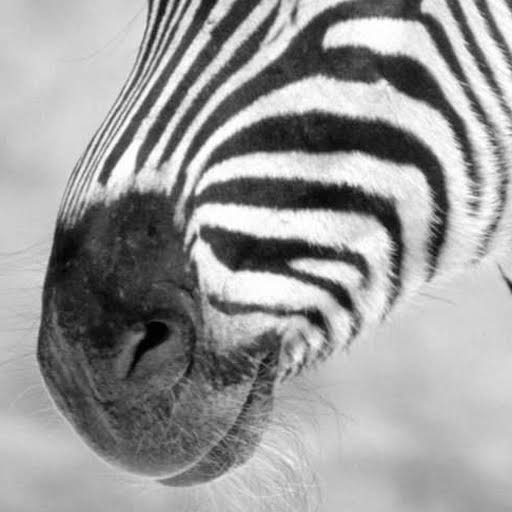

Read in zebra.jpg. Shape: (512, 512)


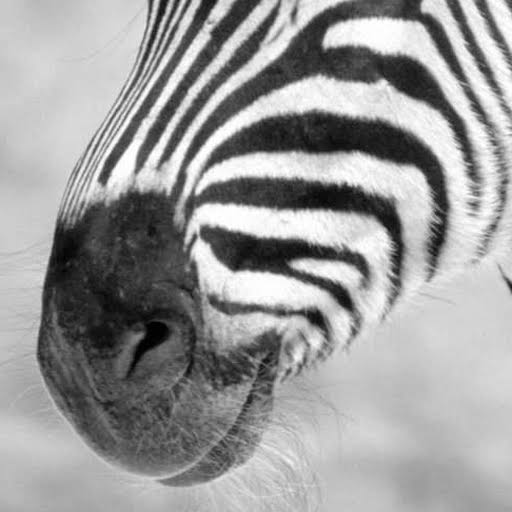

In [1]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt


# image_path = 'wall.jpg'
# image_path = 'building.jpg'
# image_path = 'bigben.jpg'
image_path = 'zebra.jpg'

resize = 1.0

# Read in image as RGB just to show
image_rgb = Image.open(image_path)

# Resize RGB image
w_rgb = int(image_rgb.width * resize)
h_rgb = int(image_rgb.height * resize)
image_rgb = image_rgb.resize((w_rgb, h_rgb))
display(image_rgb)

# Read in image as grayscale for operations
image = Image.open(image_path).convert('L')

# Resize gray image
w = int(image.width * resize)
h = int(image.height * resize)
image = image.resize((w, h))

# Store as array
image = np.array(image)

print(f'Read in {image_path}. Shape: {image.shape}')
width = image.shape[1]
height = image.shape[0]
Image.fromarray(image)

## Scale space
In SIFT, an octave is defined as an image at a certain resolution, but with increasing Gaussian blurs applied. It's recommended to have at least 5 different scales within an octave.

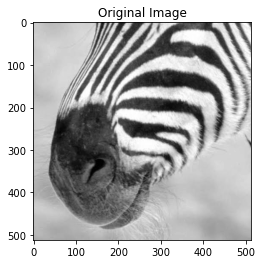

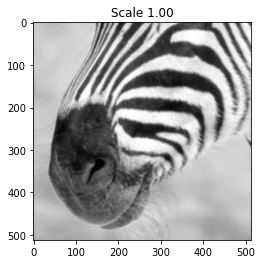

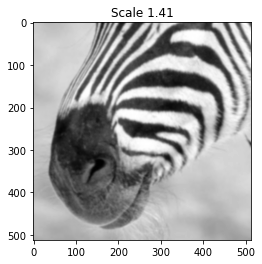

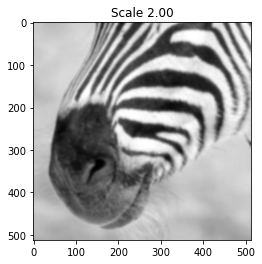

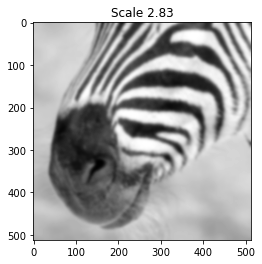

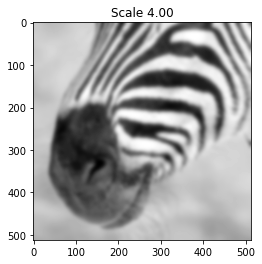

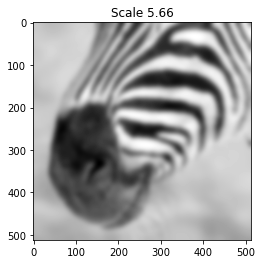

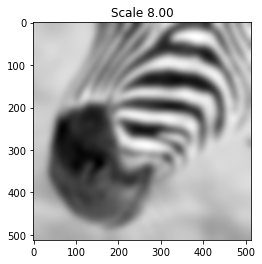

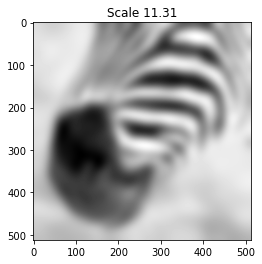

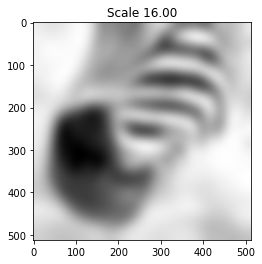

In [2]:
from scipy.ndimage import gaussian_filter
from matplotlib import pyplot as plt

scales = 5
extra = 4
scale_space = []
sigmas = [1]
multiplier = np.sqrt(2)

# Show original image
plt.figure()
plt.title('Original Image')
plt.imshow(image, cmap='gray')

for i in np.arange(scales + extra):
    scale_space.append(gaussian_filter(image.astype(np.double), sigmas[i]))
    sigmas.append(multiplier * sigmas[i])

    # Show scale space within octave
    plt.figure()
    plt.title(f'Scale {sigmas[i]:.2f}')
    plt.imshow(scale_space[i], cmap='gray')

### Top and bottom n percent removal
For visualization purposes, contrast can be improved by removing the top and bottom $n$ percent of data.

In [3]:
def RemoveTopBottomNPercent(input: np.ndarray, 
                            n: float, 
                            print_output: bool = False) -> np.ndarray:
    sorted = np.sort(np.ndarray.flatten(input))
    outliers_idx = int(n / 100 * sorted.size)

    bottom = sorted[outliers_idx]
    # If the index exceeds the size, just use the last element
    # Doesn't occur unless 0 is input for n
    top = sorted[sorted.size - outliers_idx if outliers_idx != 0 else -1]

    if print_output:
        print(f'Removing top and bottom {n:.2f}% of data.')
        print(f'Bottom: {bottom:.2f}\nTop: {top:.2f}')

    input[input < bottom] = 0
    input[input > top] = 0

    return input

## Difference of Gaussians

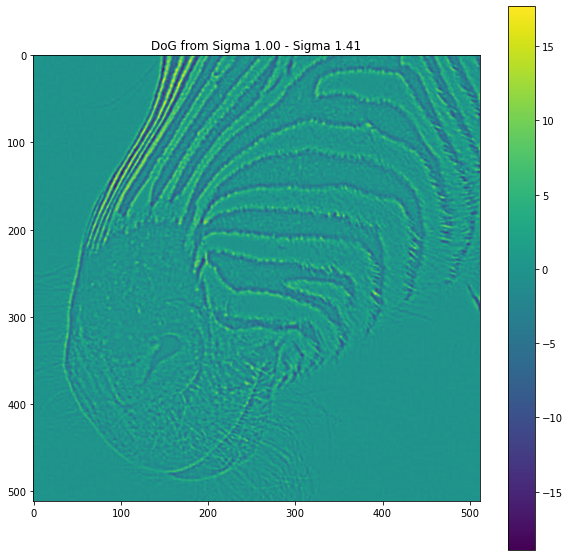

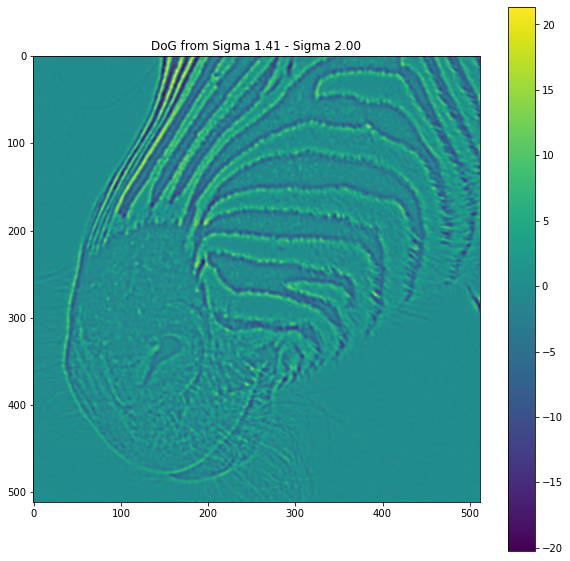

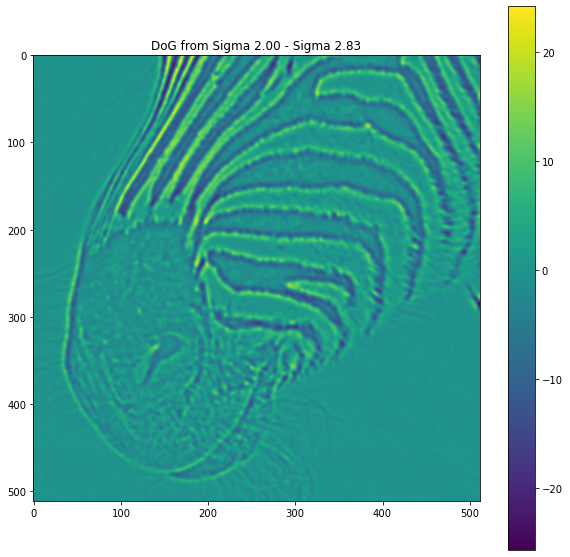

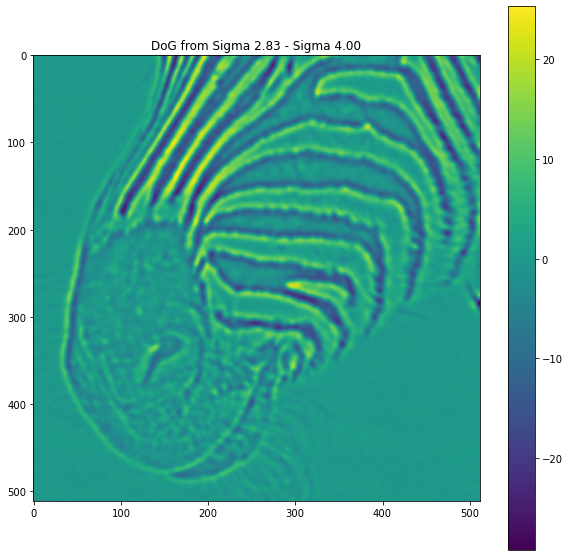

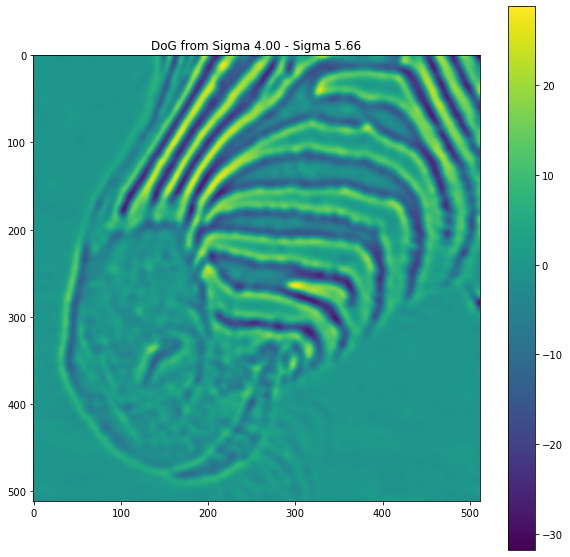

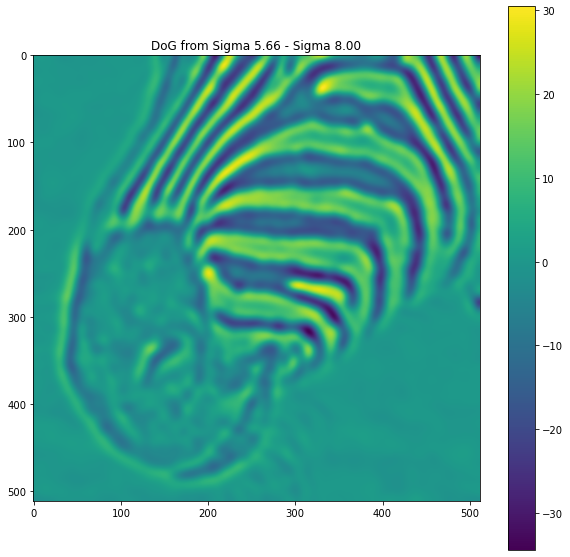

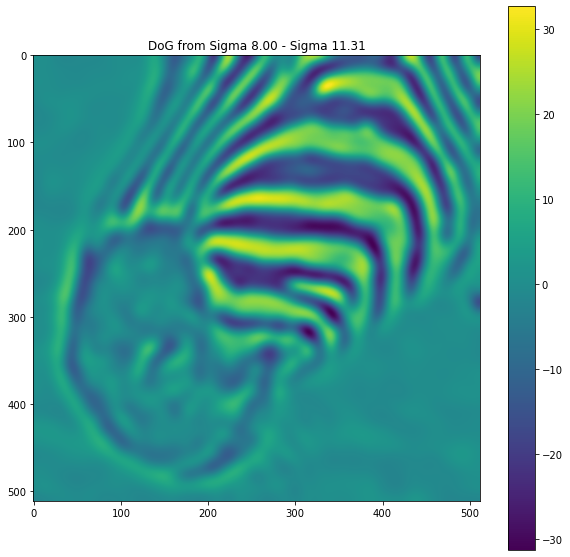

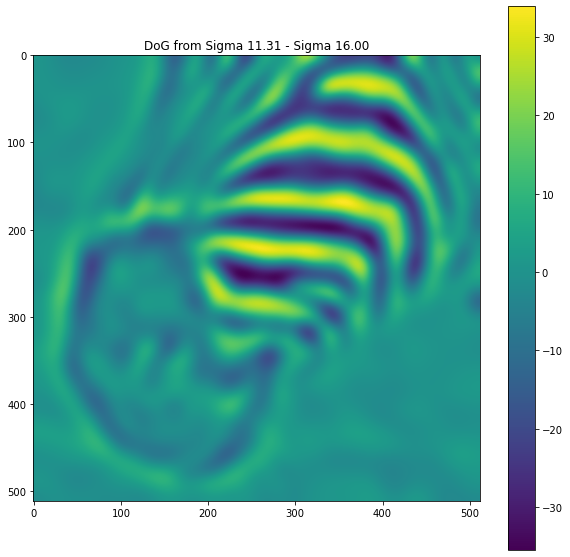

In [4]:
DoGs = []
remove_n_perc = 0

for i in np.arange(scales - 1 + extra):
    DoGs.append(scale_space[i] - scale_space[i + 1])
    plt.figure(figsize=(10,10))
    plt.title(f'DoG from Sigma {sigmas[i]:.2f} - Sigma {sigmas[i + 1]:.2f}')
    plt.imshow(RemoveTopBottomNPercent(DoGs[i], remove_n_perc))
    plt.colorbar()

## Optima in DoG
Find the optima across three scales. If a pixel is the maximum or minimum out of its 26 neighbors, it is marked as a keypoint. The smallest and largest scales will not be used for keypoints. Why is that?

![Difference of Gaussian](res/dog.png)

In [5]:
# Turn list of numpy arrays into 3D matrix, but only if it's a list
# Rerunning this cell will permute the axes if it's already a numpy array
if type(DoGs) == list:
    DoGs = np.dstack(DoGs)

rows, cols = DoGs.shape[0:2]

keypoints = []

for i in np.arange(1, scales - 1):
    for row in np.arange(1, rows - 1):
        for col in np.arange(1, cols - 1):
            candidate = DoGs[row, col, i]

            neighborhood = DoGs[row-1:row+2, col-1:col+2, i-1:i+2]
            
            maxima = (candidate > neighborhood).sum()
            minima = (candidate < neighborhood).sum()

            if maxima == 26 or minima == 26:
               keypoints.append(np.array([row, col]))

print(f'{len(keypoints)} keypoints detected.')
                
            

1848 keypoints detected.


## Plot Keypoints

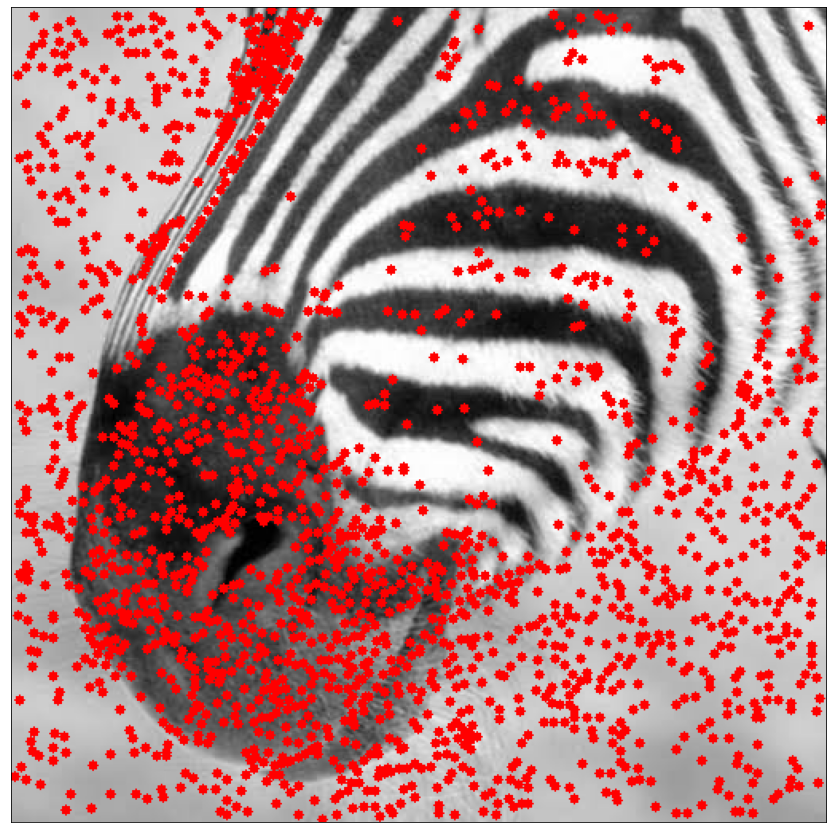

In [6]:
import cv2

image_features = cv2.imread(image_path)
image_features = cv2.resize(image_features, (w, h))
image_features = cv2.cvtColor(image_features, cv2.COLOR_BGR2RGB)
for i in np.arange(len(keypoints)):
    image_features = cv2.circle(image_features, 
                                (keypoints[i][1], keypoints[i][0]), 
                                radius=3, color=(255,0,0), thickness=-1)

plt.figure(figsize=(15,15))
plt.xticks([])
plt.yticks([])
plt.imshow(image_features)